# GLLVM Longitudinal

In [20]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import copy
from GLLVM_longitudinal import LongitudinalGLLVM

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500mb" # this ist to prevent cuda to reserve too much memory


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### Loading data
The data has been pre-processed as a 3D array with dimensions given by $(n, k+p, T)$.

The final array is a 3D array of shape (n, k+p, T), where 
* n is the number of observations, 
* k is the number of covariates,
* p is the number of responses to be modeled by the latent variables,
* T is the number of time observations

The variables are originally ordered as follows:

**Covariates**

- age (covariate)
- gender (covariate)
- education (covariate)

**Responses**

- month (binary)
- day (binary)
- year (binary)
- day_week (binary)
- paper (binary)
- cactus (binary)
- president (binary)
- vice_president (binary)
- serie_7 (count)
- backwards (ordinal)
- recall_immediate (count)
- recall_delayed (count)

The binary random variables are modelled conditionally with a logistic regression; the ordinal variables with an ordinal logistic regression; the counts with poisson regression.

The ordinal responses require an intercept for each level, or "cutpoints". In our case, we model this by hard-coding the intercept, but it should be made more general. We assume the effect of the covariates is constant across categories, resulting in a proportional odds model.

Since the ordinal variable has only 3 categories (0,1,2) and that 2 has very few non-zero elements, we will merge categories 1 and 2 and consider it as a bernoulli random variable.

**Covariates**

- 0: age (covariate)
- 1: gender (covariate)
- 2: education (covariate)

**Responses**

- 0: month (binary)
- 1: day (binary)
- 2: year (binary)
- 3: day_week (binary)
- 4: paper (binary)
- 5: cactus (binary)
- 6: president (binary)
- 7: vice_president (binary)
- 8: serie_7 (count)
- 9: backwards (dummy)
- 10: recall_immediate (count)
- 11: recall_delayed (count)

In [21]:
# Import the preprocessed data
data = np.load("../data/HRS/HRS_3Darray.npy")
data = data
print(data.shape)

(33146, 15, 9)


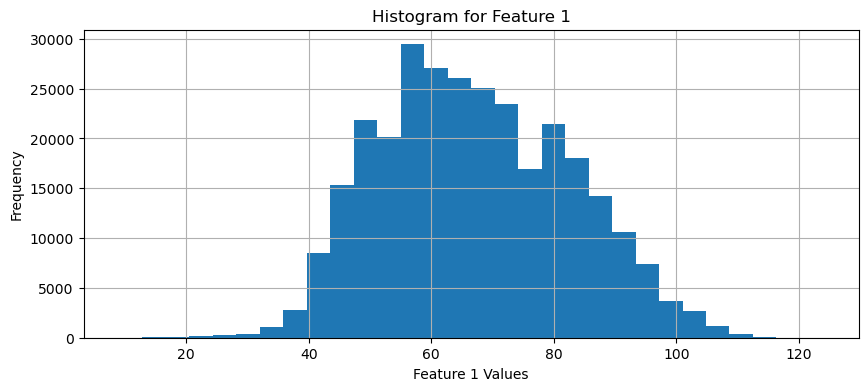

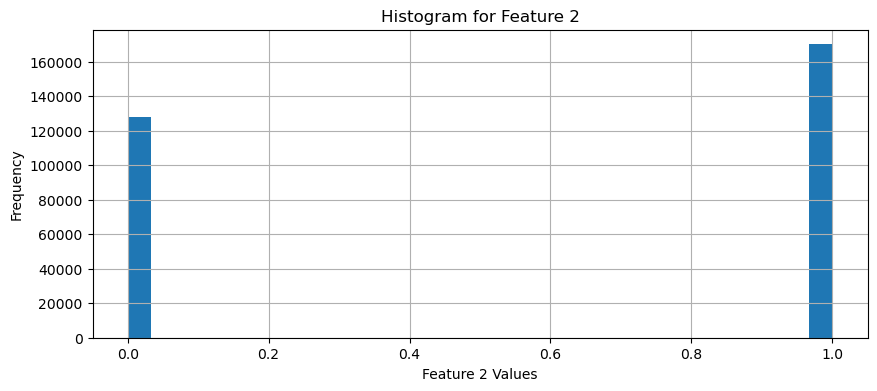

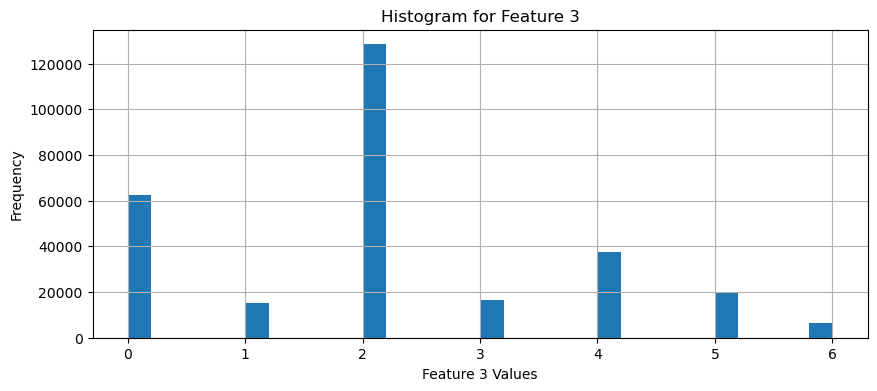

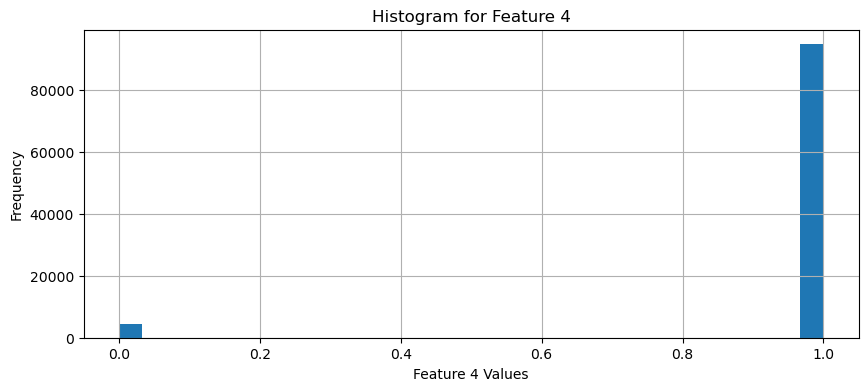

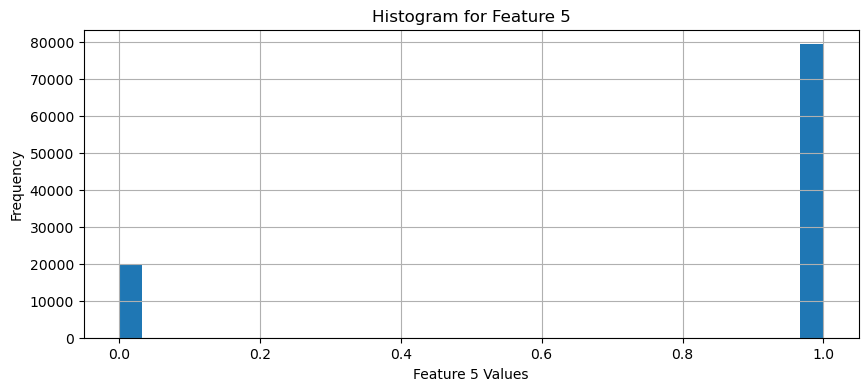

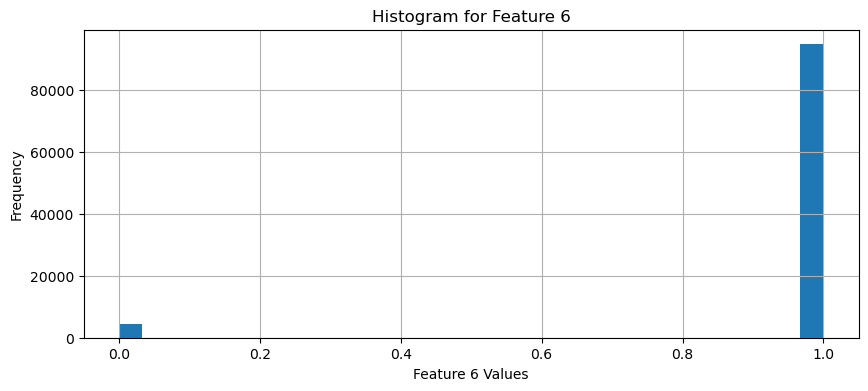

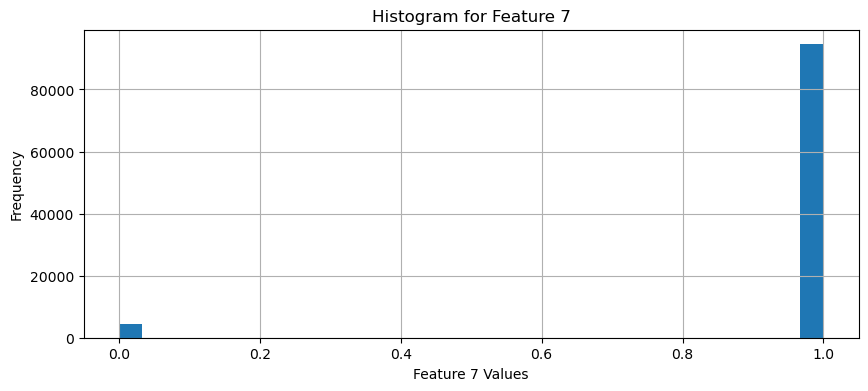

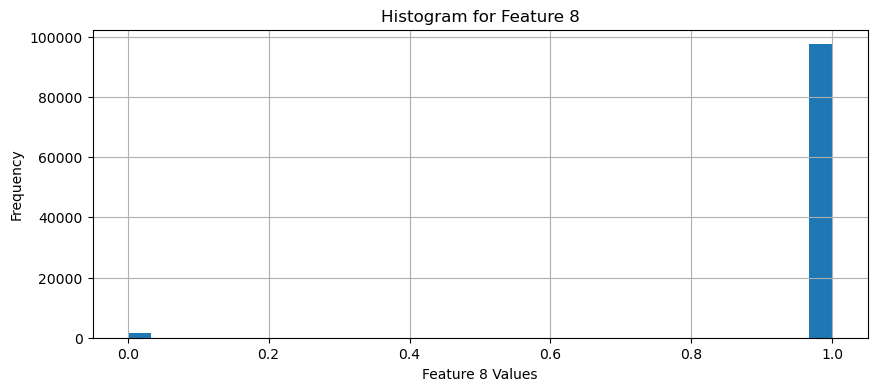

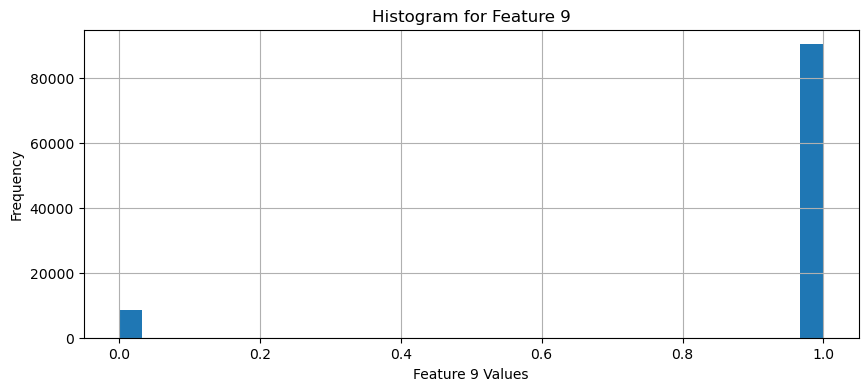

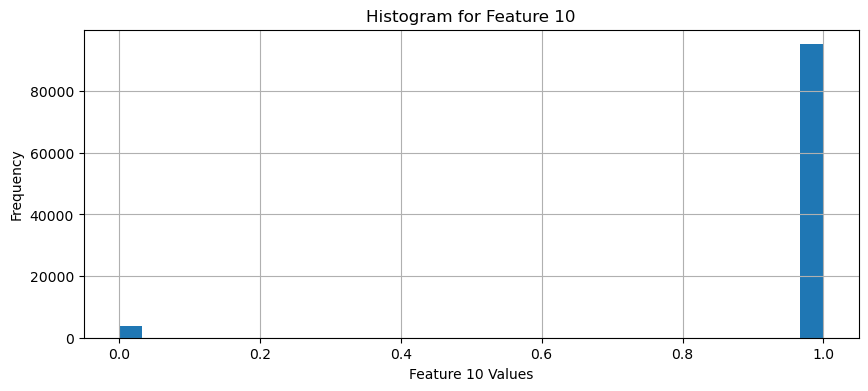

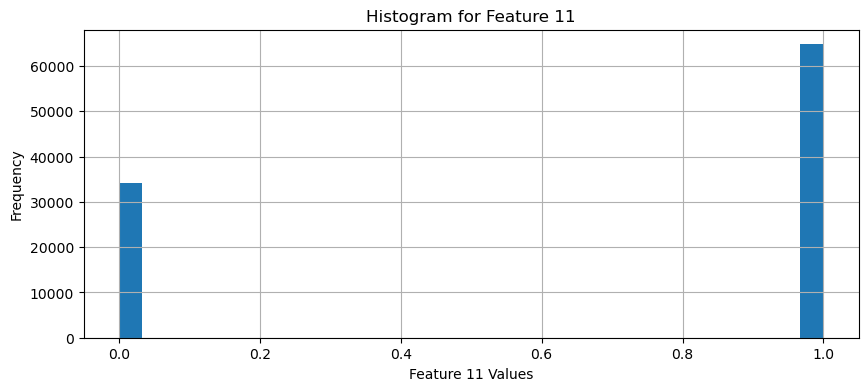

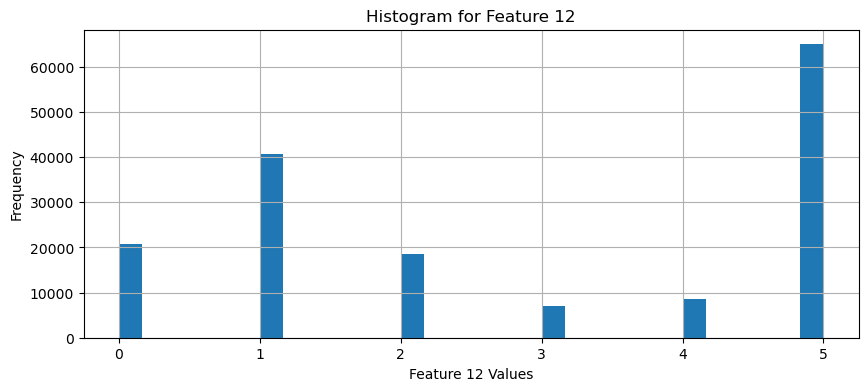

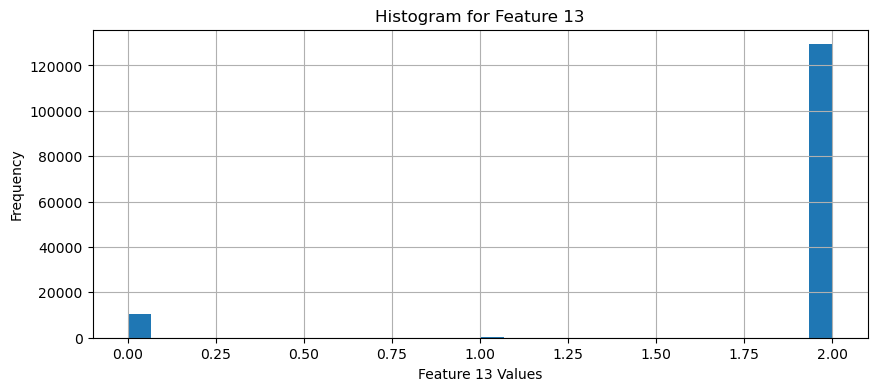

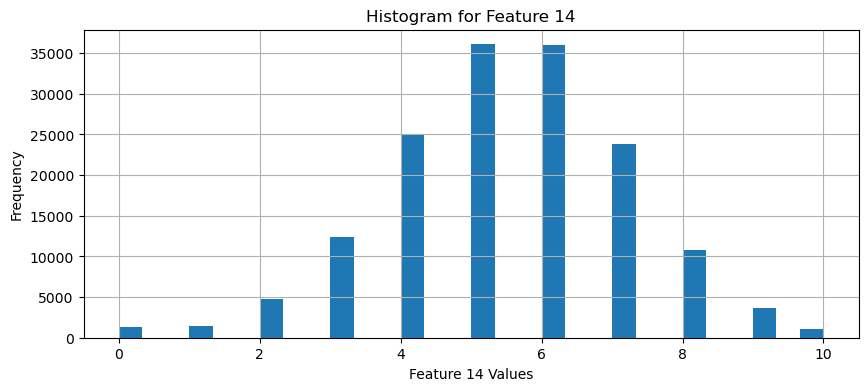

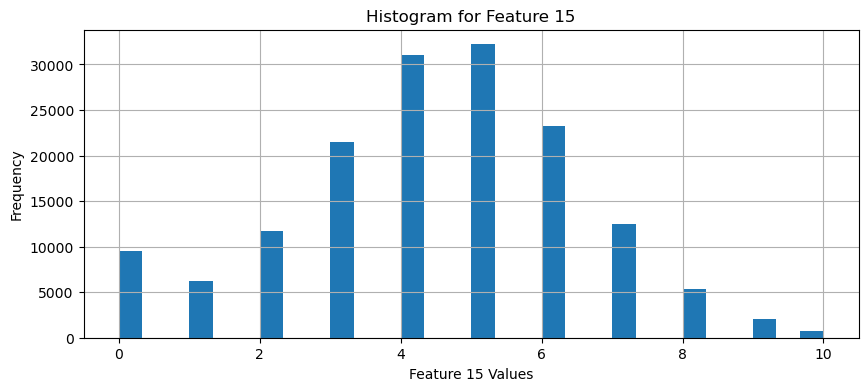

In [22]:
for i in range(data.shape[1]):
    # Get the data for this feature (flatten and filter out NaNs)
    feature_data = data[:, i].flatten()
    valid_data = feature_data[~np.isnan(feature_data)]  # filtering out NaN values

    plt.figure(figsize=(10, 4))
    plt.hist(valid_data, bins=30)
    plt.title(f'Histogram for Feature {i+1}')
    plt.xlabel(f'Feature {i+1} Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [23]:
# Create the backwards dummy
data[:,12] = data[:,12]>=1

In [24]:
data[:,12]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [25]:
# Transpose the data from (batch_length, num_features, seq_length) to  (batch_length, seq_length, num_features)
# Separate covariates and responses, and prepare the torch tensors
data = np.transpose(data, (0,2,1))
data_true = {
    'x': torch.from_numpy(data[:,:,:3]).float(),
    'y': torch.from_numpy(data[:,:,3:]).float()
}

# data_true['y'] = data_true['y'][:,:,:8]

# TODO: ignognoring problematic variable
data_true['y'] = torch.cat([data_true['y'][:,:,:9], data_true['y'][:,:,10:]], dim=2)

In [26]:
data_true['y']

tensor([[[1., 1., 1.,  ..., 3., 4., 3.],
         [1., 1., 1.,  ..., 4., 3., 3.],
         [1., 1., 1.,  ..., 2., 5., 7.],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[1., 1., 1.,  ..., 5., 6., 6.],
         [1., 1., 1.,  ..., 5., 5., 6.],
         [1., 1., 1.,  ..., 3., 5., 5.],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., 5., 7., 5.],
         [1., 1., 1.,  ..., 5., 7., 6.],
         [1., 1., 1.,  ..., 5., 7., 5.],
         ...,
         [1., 1., 1.,  ..., 4., 5., 5.],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
        

##  dealing with missing data
We deal with missing data in two ways:

* The missing values are iteratively imputed by their conditional mean.
* To compute the Z, we use the imputed means.
* To compute the parameters, we use the imputed means and estimated Z but *provide the mask* so that the update does not take the missing values into account in the computation of the gradient.


In [27]:
mask = {}

mask['x'] = torch.isnan(data_true['x'])
mask['y'] = torch.isnan(data_true['y'])

data_true['x'][mask['x']] = 0.5
data_true['y'][mask['y']] = 0.5



# Data standardization

To improve numerical stability, we transform the counts as $y\to \log(y+1)$. This is reflected in the sampling mechanics. As a result, we use the identity as a link function for the counts.

In [28]:
# Numerical stability issues for poisson data
data_true['x'][:,:,0] = data_true['x'][:,:,0] /20


# Add intercepts and time information
time_data = torch.from_numpy(np.linspace(0,4,9)).float().expand(data_true['x'].shape[0], -1).unsqueeze(2)

add_intercept = False # already in the model

if add_intercept:
    intercepts = torch.ones_like(data_true['x'][:,:,0]).unsqueeze(2)
    data_true['x'] = torch.cat([intercepts, data_true['x'], time_data], dim=2)
else:
    data_true['x'] = torch.cat([data_true['x'], time_data], dim=2)


# Compute mean and std along the batch_size and seq_length dimensions
mean = data_true['x'].mean(dim=(0,1), keepdim=True)
std = data_true['x'].std(dim=(0,1), keepdim=True)

# Normalize data
data_true['x'] = (data_true['x'] - mean) / (std + 1e-7) 


print(data_true['x'][0])




tensor([[ 0.0611, -1.1526, -0.0365, -1.5492],
        [ 0.1903, -1.1526, -0.0365, -1.1619],
        [ 0.3195, -1.1526, -0.0365, -0.7746],
        [ 0.4486, -1.1526, -0.0365, -0.3873],
        [ 0.5778, -1.1526, -0.0365,  0.0000],
        [ 0.7070, -1.1526, -0.0365,  0.3873],
        [ 0.8362, -1.1526, -0.0365,  0.7746],
        [ 0.9654, -1.1526, -0.0365,  1.1619],
        [ 1.0945, -1.1526, -0.0365,  1.5492]])


## Building the GLLVM Longitudinal Model

A Longitudinal GLLVM is a model with 1 variable per period for T periods, n observations, and p responses, and k covariates. We also have a random effect for each observation x response.

In [29]:
n = data_true['y'].shape[0]
p = data_true['y'].shape[2]
q = 1
k = data_true['x'].shape[2] # including intercept and time variable
T = data_true['y'].shape[1]

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

In [30]:

response_types = {
    'binary': [0,1,2,3,4,5,6,7, 9],
    'counts': [8, 10, 11]
}


# when removing the 9th variable...

response_types = {
    'binary': [0,1,2,3,4,5,6,7],
    'counts': [8, 9, 10]
}

In [31]:


model = LongitudinalGLLVM(num_var = p, num_latent = q, num_covar=k, num_period=T, response_types=response_types, intercept=True)

model.load_state_dict(torch.load("fit_study_without-9_all-obs.pth"))

<All keys matched successfully>

They can be of many response types. Here for the sake of illutration we will consider 3 response types: gaussian, binary, and poisson.

We allow for transformation of the data, which we account for in the estimation. In particular, Poisson data may be numerically problematic because their conditional expectation is the exponential of the linear predictor. Small differences in the latter can result in dramatic differences in the gradient. For instance, we can transform poisson with the following function $x \rightarrow \log(x+1)$. This transforms is needed in 2 places: for encoding, and at the loss function for computing the gradient.

## Computing the scale parameter

The scale parameter is computed in a second step (on the fit residual). They are updated at every iteration.


### Modules

We need LongitudinalGLLVM as the overarching module, Sample which samples the data and takes additional arguments (such as nuisance parameters), Decoder which contains all the parameters of interest, and Encoder which encodes the data using a Neural Network.

### Design of the Encoder
Since the estimation problem for Z is the same at each time step, we model the encoder using a RNN. At each time step, the same encoder is used to compute the Z. At the same time, the hidden state of the RNN is used to predict the U variable, which is constant over time for each observation.

In [32]:
# Define and train the model
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, covariates, responses, mask):
        self.covariates = covariates
        self.responses = responses
        self.mask = mask

    def __len__(self):
        return len(self.covariates)

    def __getitem__(self, idx):
        return self.covariates[idx], self.responses[idx], self.mask[idx]

from torch.utils.data import DataLoader


# Create dataset
dataset = MyDataset(data_true['x'], data_true['y'], mask['y'])




In [68]:
# Define the data loader
batch_size = 10000 
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda")
model.to(device)

for epoch in range(2):
    for x, y, m in data_loader:
        x, y, m = x.to(device), y.to(device), m.to(device)
# # Change to device
# data_true = {key:val.to(device) for key, val in data_true.items()}
# mask = {key:val.to(device) for key, val in mask.items()}
        fit=model.fit(x=x, y=y, mask=m, epochs=100, lr_model=0.01, lr_encoder=0.005, phi_ub=.45, varu_lb=.05, varu_ub=1.)

var_u: Parameter containing:
tensor([0.4000], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4500], device='cuda:0', requires_grad=True)

Epoch 1/100, loss_fit = 1.59, encoder_loss = 0.96.
var_u: Parameter containing:
tensor([0.4000], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4500], device='cuda:0', requires_grad=True)

Epoch 2/100, loss_fit = 1.65, encoder_loss = 0.96.
var_u: Parameter containing:
tensor([0.4000], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4500], device='cuda:0', requires_grad=True)

Epoch 3/100, loss_fit = 1.62, encoder_loss = 0.95.
var_u: Parameter containing:
tensor([0.4000], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4500], device='cuda:0', requires_grad=True)

Epoch 4/100, loss_fit = 1.61, encoder_loss = 0.95.
var_u: Parameter containing:
tensor([0.4000], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4500], devi

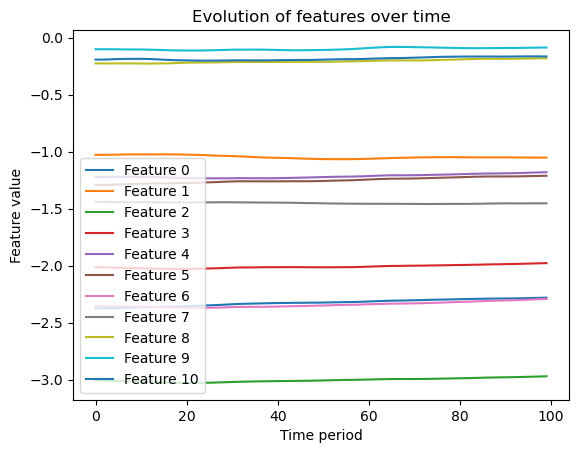

In [69]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['loading_values']], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

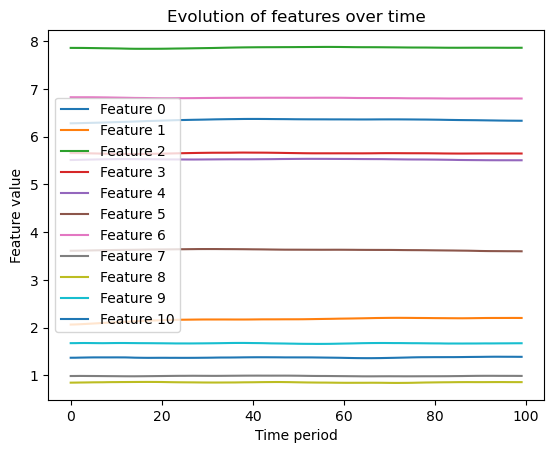

In [70]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['intercept_values']], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

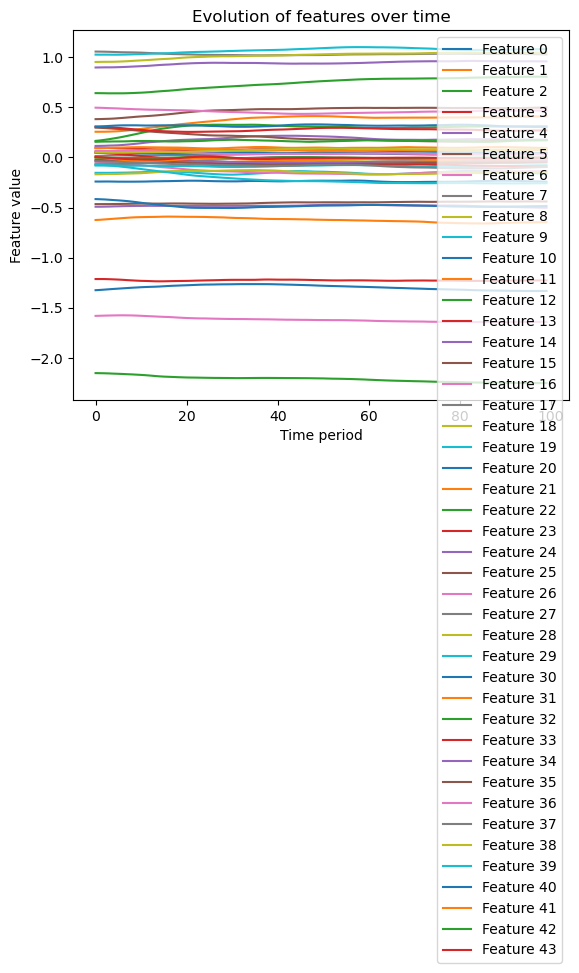

In [71]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['coef_values']], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

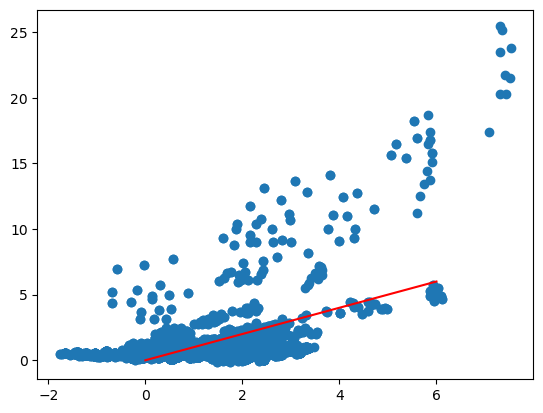

In [76]:
# Change to device
device=torch.device("cpu")
model.to(device)
data_true = {key:val.to(device) for key, val in data_true.items()}
mask = {key:val.to(device) for key, val in mask.items()}

# # impute by the mean
y_imputed = model.mean_impute(data_true['y'], mask['y']).detach()
y_sim = model.sample(x=data_true['x'])['y'].detach()
y_sim_imputed = model.mean_impute(y_sim, mask['y']).detach()


# Transform?
transform = False

if transform:
    with torch.no_grad():
        y_imputed = model.transform_responses(y_imputed)
        y_sim_imputed = model.transform_responses(y_sim_imputed)


dat1 = torch.reshape(y_imputed, (data_true['y'].shape[0], -1))
cor1 = np.corrcoef(dat1, rowvar=False)
cor1 = np.cov(dat1, rowvar=False)
dat2 = torch.reshape(y_sim_imputed, (data_true['y'].shape[0], -1))
cor2 = np.corrcoef(dat2, rowvar=False)
cor2 = np.cov(dat2, rowvar=False)


plt.scatter(cor1, cor2)
plt.plot([0,6],[0,6], color="red")
plt.show()

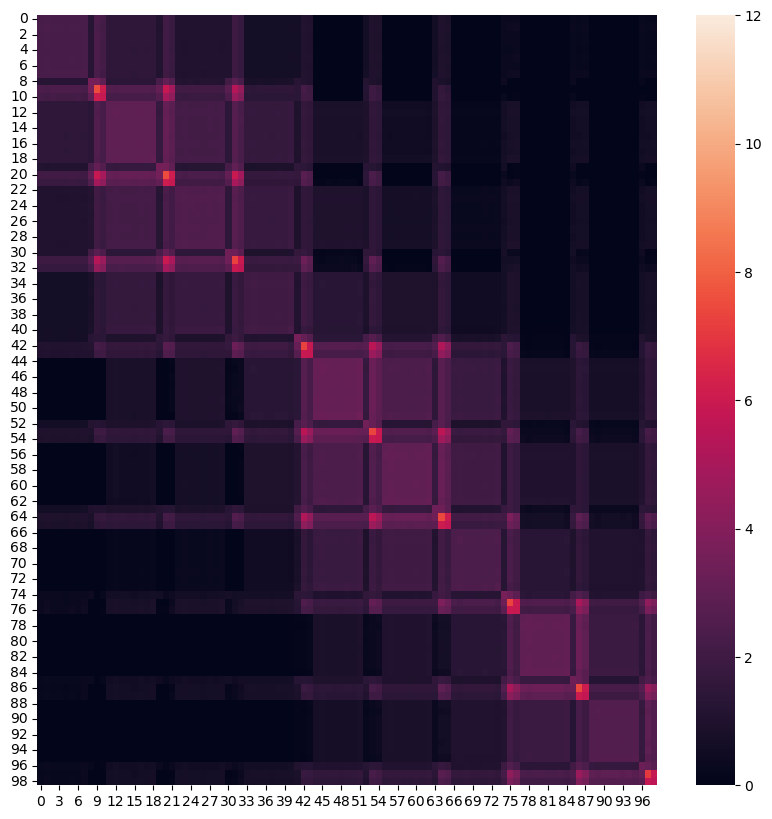

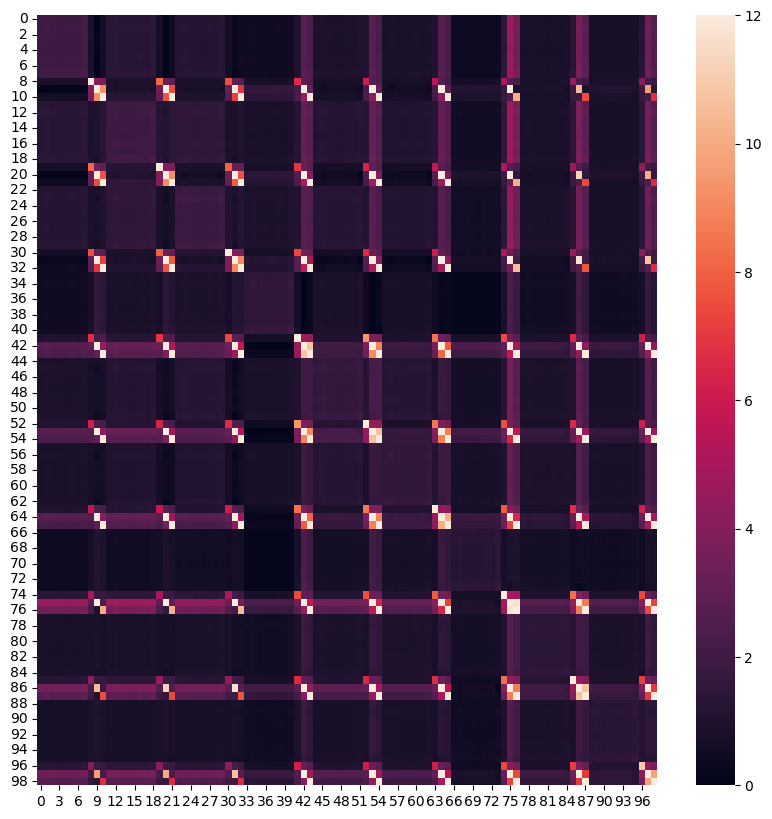

In [74]:




plt.figure(figsize=(10,10))
sns.heatmap(cor1, annot=False, fmt='g', vmin=0, vmax=12)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(cor2*2, annot=False, fmt='g', vmin=0, vmax=12)
plt.show()

In [51]:
save_path = "fit_study_without-9_all-obs.pth"

torch.save(model.state_dict(), save_path)



In [ ]:
# save_path = "fit_study_without9.pth"
# model = LongitudinalGLLVM(num_var = p, num_latent = q, num_covar=k, num_period=T, response_types=response_types, intercept=True)
# model.load_state_dict(torch.load(save_path))